[ 0.04666424]
Optimization terminated successfully.
         Current function value: 733.978444
         Iterations: 18
         Function evaluations: 40


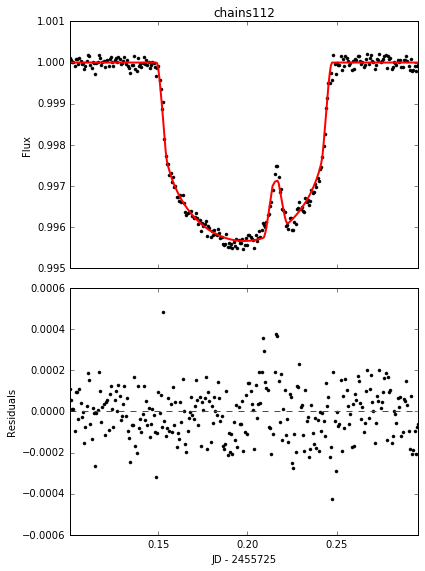

In [1]:
%matplotlib inline

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

# Import dev version of friedrich:
import sys
sys.path.insert(0, '../../')
from friedrich.analysis import MCMCResults
from friedrich.lightcurve import hat11_params_morris
from friedrich.stsp import STSP
from glob import glob
import matplotlib.pyplot as plt

import batman
import os, subprocess
import numpy as np
from astropy.io import ascii
from astropy.table import Table
from scipy.optimize import fmin_powell, minimize, fmin


paths = sorted(glob('/local/tmp/friedrich/hat11/chains???.hdf5'))
#for path in paths:
path = '/local/tmp/friedrich/hat11/chains112.hdf5'
m = MCMCResults(path, hat11_params_morris())
thetas, phis = m.max_lnp_theta_phi_stsp()


def spot_model(radii, mcmc, thetas=thetas, phis=phis):
    if len(thetas) > 1:
        spot_params = []
        for r, t, p in zip(radii, thetas, phis):       
            spot_params.extend([r, t, p])
    else:
        spot_params = [radii[0], thetas[0], phis[0]]


    s = STSP(mcmc.lc, mcmc.transit_params, spot_params)
    t_model, f_model = s.stsp_lc()
    return t_model, f_model



def spot_chi2(radii, mcmc=m):
    t_model, f_model = spot_model(radii, mcmc=mcmc)

    first_ind = 0
    eps = 1e-5
    if np.abs(t_model.data[0] - mcmc.lc.times.jd[0]) > eps:
        for ind, time in enumerate(mcmc.lc.times.jd):
            if np.abs(t_model.data[0] - time) < eps:
                first_ind = ind
    chi2 = np.sum((mcmc.lc.fluxes[first_ind:] - f_model)**2 / 
                  mcmc.lc.errors[first_ind:]**2)
    return chi2

init_radii = np.zeros(len(thetas)) + 0.8*m.transit_params.rp
print(init_radii)

best_radii = fmin(spot_chi2, init_radii[:])

if len(best_radii.shape) == 0:
    best_radii = [best_radii.tolist()]

best_t, best_f = spot_model(best_radii, m)

fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
minjdint = int(np.min(m.lc.times.jd))
ax[0].plot(m.lc.times.jd - minjdint, m.lc.fluxes, 'k.')
ax[0].plot(best_t - minjdint, best_f, 'r', lw=2)
ax[0].set(ylabel='Flux',
          xlim=(np.min(m.lc.times.jd - minjdint), 
                np.max(m.lc.times.jd - minjdint)),
          ylim=(0.995, 1.001), 
          title='{0}'.format(m.index))
ax[1].set(xlabel='JD - {0}'.format(minjdint), ylabel='Residuals')

ax[1].plot(m.lc.times.jd - minjdint, m.lc.fluxes - best_f, 'k.')
ax[1].axhline(0, ls='--', color='r')
fig.tight_layout()
#plt.savefig('tmp/{0}.png'.format(m.index), bbox_inches='tight')
#plt.close()
    #plt.show()

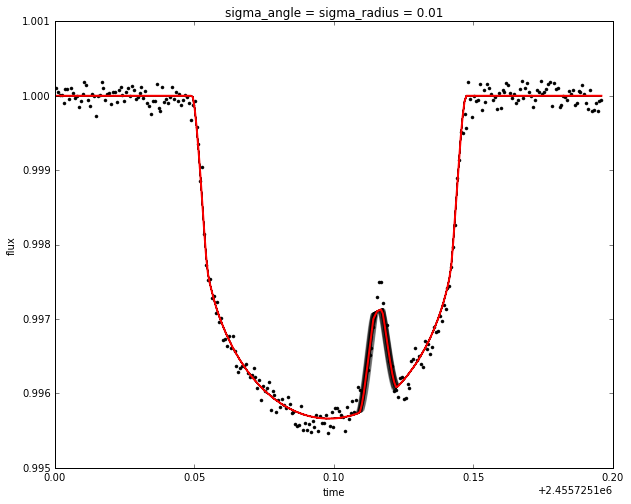

In [2]:

def spot_model_vary(radii, mcmc, thetas=thetas, phis=phis):
    if len(thetas) > 1:
        spot_params = []
        for r, t, p in zip(radii, thetas, phis):       
            spot_params.extend([r, t, p])
    else:
        spot_params = [radii[0], thetas[0], phis[0]]


    s = STSP(mcmc.lc, mcmc.transit_params, spot_params)
    t_model, f_model = s.stsp_lc()
    return t_model, f_model

constant = 0.01

plt.figure(figsize=(10, 8))
plt.plot(m.lc.times.jd, m.lc.fluxes, 'k.')
for i in range(100):
    rand_r = constant*np.random.randn(len(thetas)) + best_radii
    rand_theta = constant*np.random.randn(len(thetas)) + thetas
    rand_phi = constant*np.random.randn(len(thetas)) + phis
    
    t, f = spot_model_vary(rand_r, m, rand_theta, rand_phi)
    plt.plot(t, f, alpha=0.2, color='k')
    
plt.plot(best_t, best_f, color='r', lw=2)
plt.title('sigma_angle = sigma_radius = {0}'.format(constant))
plt.ylabel('flux')
plt.xlabel('time')
plt.savefig('sigma0.5.png',bbox_inches='tight')